### Neural Networks to fit $x = \cos(\theta)$ and $\theta = \arccos(x)$

In [1]:
# Library imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time

# Aliases
keras = tf.keras

In [2]:
# Local imports
from utils import gpu_grow_memory, TimeHistory, EpochLoss, plot_loss_hist
from utils import load_vartbl, save_vartbl, plot_style

from polar_coord import make_data_cos, make_dataset_cos
from polar_coord import make_models_cos_math, make_model_pow
from polar_coord import compile_and_fit, make_model_autoencoder

In [3]:
# Grow GPU memory (must be first operation in TF)
gpu_grow_memory()

In [4]:
# Plot style 
plot_style()

In [5]:
# Lightweight serialization
fname = '../pickle/polar_coord.pickle'
vartbl = load_vartbl(fname)

## Create datasets for $\theta \in [0, \pi]$ and $x \in [-1, 1]$

In [13]:
# Make datasets for cos
n = 36000
data_cos = make_data_cos(n)
ds_p2c, ds_c2p, ds_p2p, ds_c2c = make_dataset_cos(n=n, batch_size=3600)

In [32]:
# Set number of epochs
epoch_size = n+1
epochs = (20000 * 3600) // n
samples_total = epochs * epoch_size

# Set save_freq in terms of SAMPLES
save_freq = samples_total // 10

# Print summary
print(f'Built data set with n={n:,}.')
print(f'Training for {epochs} epochs total, with {samples_total:,} sample points total.')
print(f'Save frequency every {save_freq:,} samples.')

Built data set with n=36,000.
Training for 2000 epochs total, with 72,002,000 sample points total.
Save frequency every 7,200,200 samples.


In [15]:
# # Unpack one example batch
# batch_theta, batch_x = list(ds_p2c.take(10))[0]
# batch_theta, batch_x = batch_theta.numpy(), batch_x.numpy()

# # Review data contents
# print(f'batch size: {batch_theta.shape[0]}')
# print(f'theta: min={np.min(batch_theta):+8.5}, max={np.max(batch_theta):+8.5}')
# print(f'    x: min={np.min(batch_x):+8.5}, max={np.max(batch_x):+8.5}')

In [16]:
theta = data_cos['theta']
x = data_cos['x']

## Deterministic Mathematical Models

In [17]:
# Mathematical models
math_p2c, math_c2p, math_p2p, math_c2c = make_models_cos_math()

In [18]:
# Set loss function and optimizer
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam()
metrics = [keras.metrics.MeanAbsoluteError()]

In [19]:
# Compile the math models
math_p2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
math_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [20]:
# Evaluate the p2c math model
# math_p2c.evaluate(theta, x)
math_p2c.evaluate(ds_p2c)

11/11 [==============================] - 0s 15ms/step - loss: 3.4136e-16 - mean_absolute_error: 7.5547e-09


[3.4136186013216714e-16, 7.554678e-09]

In [21]:
# Evaluate the c2p math model
# math_c2p.evaluate(x, theta)
math_c2p.evaluate(ds_c2p)

11/11 [==============================] - 0s 14ms/step - loss: 6.1606e-12 - mean_absolute_error: 1.2392e-07


[6.160566892677059e-12, 1.2391568e-07]

In [22]:
# Evaluate the p2p math model
# math_p2p.evaluate(theta, theta)
math_p2p.evaluate(ds_p2p)

11/11 [==============================] - 0s 15ms/step - loss: 2.7439e-12 - mean_absolute_error: 1.0756e-07


[2.7439248260003936e-12, 1.0756175e-07]

In [23]:
# Evaluate the c2c math model
# math_c2c.evaluate(x, x)
math_c2c.evaluate(ds_c2c)

11/11 [==============================] - 0s 14ms/step - loss: 1.4074e-15 - mean_absolute_error: 1.6916e-08


[1.4073553773822638e-15, 1.6916488e-08]

## Functions for visualizing neural network outputs $x = \cos(\theta)$

In [24]:
def plot_pred_cos(model, theta):
    # Predictions of the model
    x_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    # cos(theta) from power series up to theta^8
    # fact = np.math.factorial
    # x_pow = 1.0 - theta**2 / fact(2) + theta**4 / fact(4) - theta**6 / fact(6) + theta**8 / fact(8)
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('$x$')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.set_ylim(-1.05, 1.05)
    ax.set_yticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(theta, x, color='blue', label='$\cos(\\theta)$', linewidth=4.0)
    ax.plot(theta, x_pred, color='red', label='NN$(\\theta)$', linewidth=2.0)
    # ax.plot(theta, x_pow, color='orange', label='power ser', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [25]:
def plot_error_cos(model, theta):
    # Predictions of the model
    x_pred = model.predict(theta)
    x_pred = x_pred.reshape((-1,))
    error = x_pred - np.cos(theta)
    
    # Plot errors
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error for $x = \\cos(\\theta)$ in {model.name}')
    ax.set_xlabel('$\\theta$')
    ax.set_ylabel('error = $\cos(\\theta)$ - NN($\\theta$)')
    ax.set_xlim(0.0, np.pi)
    ax.set_xticks(np.linspace(0.0, np.pi, 5))
    ax.set_xticklabels(['$0$', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(theta, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    # ax.legend()
    return fig, ax

## Neural networks for $x = \cos(\theta)$

### Network Design 0: [ ]
model_cos_ has only feature augmentation layers with even powers of theta

In [27]:
# Build the NN model of y=cos(theta)
model_cos_ = make_model_pow(func_name='cos', 
                            input_name='theta',
                            output_name='x',
                            powers=[2,4,6,8],
                            skip_layers=False,
                            hidden_sizes=[])

model_cos_.compile(loss=loss, optimizer=optimizer, metrics=metrics)

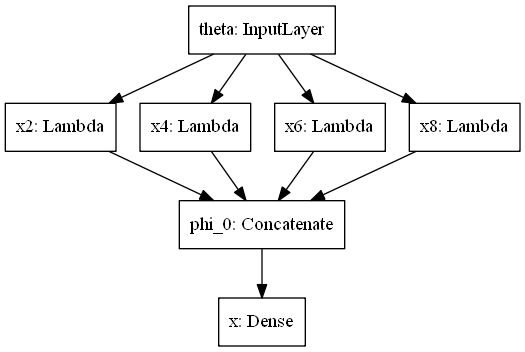

In [28]:
keras.utils.plot_model(model_cos_, show_shapes=False)

In [29]:
model_cos_.summary()

Model: "model_cos_[]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x2 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x4 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x6 (Lambda)                     (None, 1)            0           theta[0][0]                      
_______________________________________________________________________________________

In [30]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_.load_weights('../models/polar/model_cos_[].h5')
    model_cos_.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_ = vartbl['hist_cos_']
    print('Loaded model_cos_.')
except:
    hist = compile_and_fit(model=model_cos_, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_ = hist.history
    vartbl['hist_cos_'] = hist_cos_
    save_vartbl(vartbl, fname)

Epoch 0001; loss 1.08e+01; elapsed 0:00:01
Epoch 0100; loss 7.80e-01; elapsed 0:00:11
Epoch 0200; loss 2.46e-01; elapsed 0:00:22
Epoch 0300; loss 1.26e-01; elapsed 0:00:32
Epoch 0400; loss 7.62e-02; elapsed 0:00:43
Epoch 0500; loss 3.49e-02; elapsed 0:00:54
Epoch 0600; loss 9.85e-03; elapsed 0:01:05
Epoch 0700; loss 1.67e-03; elapsed 0:01:15
Epoch 0800; loss 6.59e-04; elapsed 0:01:26
Epoch 0900; loss 5.51e-04; elapsed 0:01:37
Epoch 1000; loss 4.17e-04; elapsed 0:01:47
Epoch 1100; loss 2.60e-04; elapsed 0:01:58
Epoch 1200; loss 1.20e-04; elapsed 0:02:09
Epoch 1300; loss 3.58e-05; elapsed 0:02:20
Epoch 1400; loss 8.17e-06; elapsed 0:02:31
Epoch 1500; loss 4.30e-06; elapsed 0:02:41
Epoch 1600; loss 4.01e-06; elapsed 0:02:52
Epoch 1700; loss 3.91e-06; elapsed 0:03:03
Epoch 1800; loss 3.67e-06; elapsed 0:03:13
Epoch 1900; loss 3.45e-06; elapsed 0:03:24
Epoch 2000; loss 3.24e-06; elapsed 0:03:35


In [31]:
model_cos_.evaluate(ds_p2c)

11/11 [==============================] - 0s 18ms/step - loss: 3.9092e-06 - mean_absolute_error: 0.0018


[3.909190066441294e-06, 0.001841555]

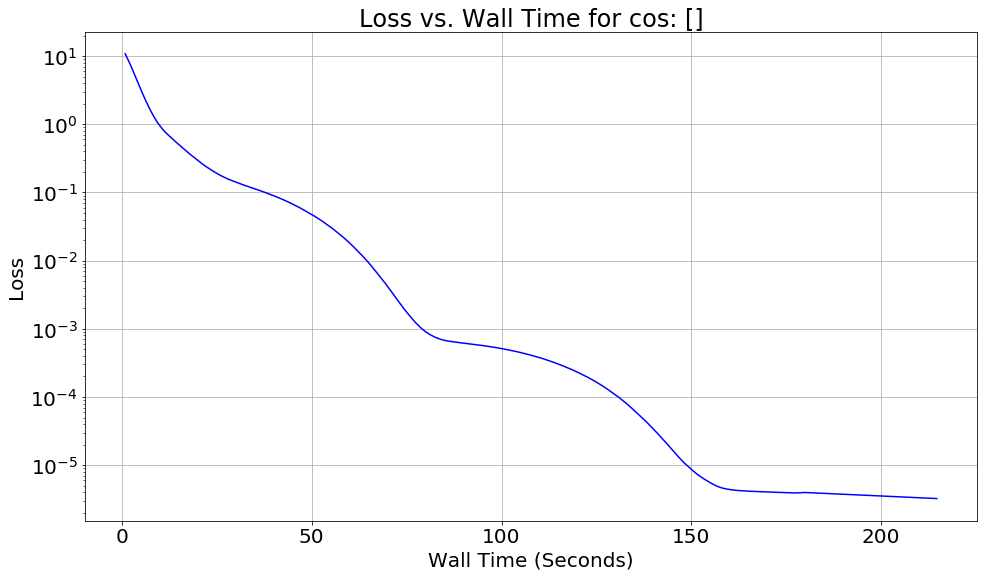

In [33]:
fig, ax = plot_loss_hist(hist_cos_, 'cos: []')

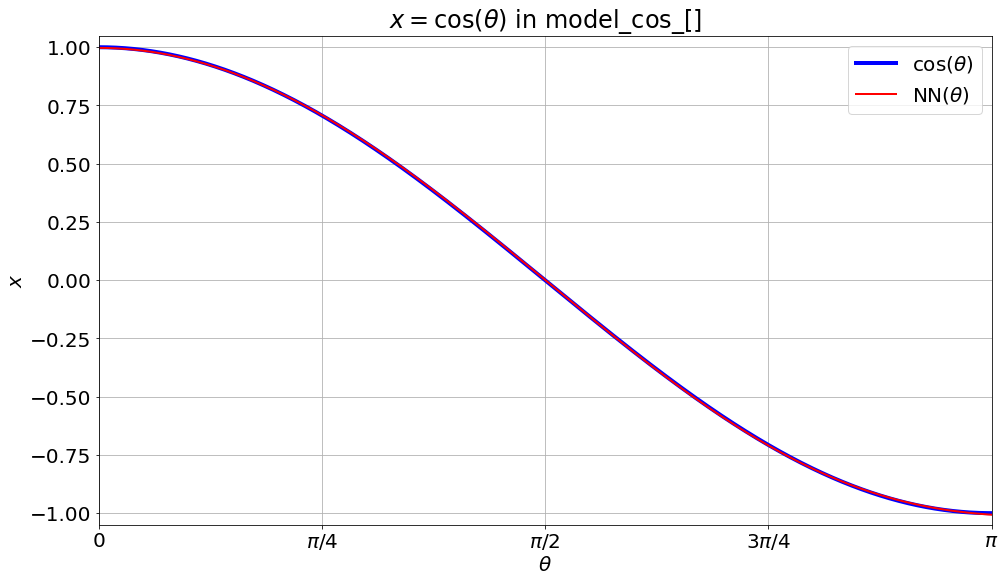

In [34]:
fig, ax = plot_pred_cos(model_cos_, theta)

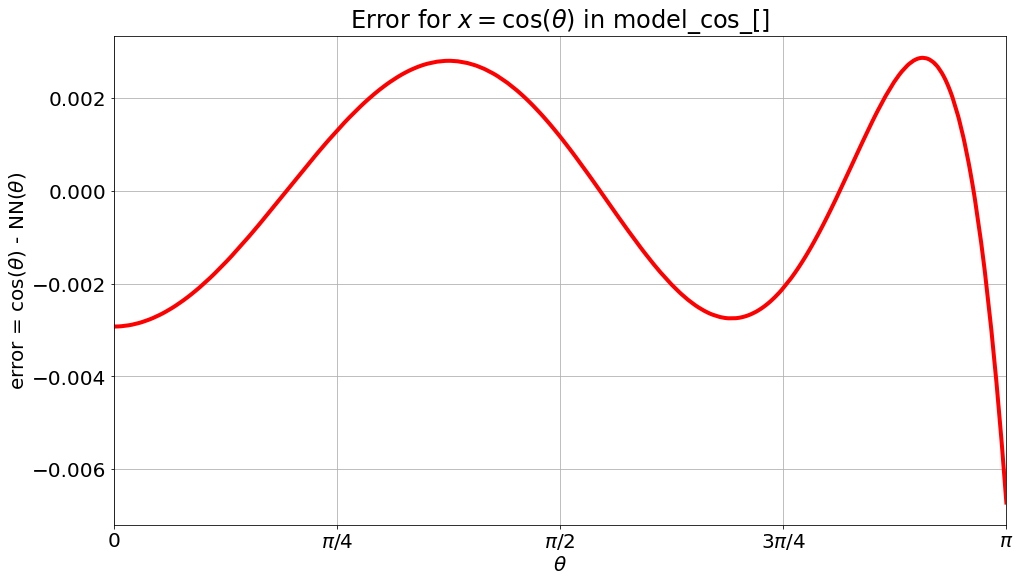

In [44]:
fig, ax = plot_error_cos(model_cos_, theta)

### Compare learned weights to those expected in power series expansion

In [35]:
wts = np.zeros(5)
wts[0] = model_cos_.weights[1].numpy()
wts[1:5] = model_cos_.weights[0].numpy().flatten()
wts
print(f' p  : True   :  Learned :  Error')
for n in range(5):
    p = 2*n
    coef_true = (-1) ** (n)
    coef_learned = wts[n]
    coef_err = coef_learned - coef_true
    print(f'{p:2}   {coef_true:+6.4f}   {coef_learned:+6.4f}    {coef_err:+6.4f}')

 p  : True   :  Learned :  Error
 0   +1.0000   +0.9971    -0.0029
 2   -1.0000   -0.9807    +0.0193
 4   +1.0000   +0.8771    -0.1229
 6   -1.0000   -0.3651    +0.6349
 8   +1.0000   -1.0058    -2.0058


### Network Design 1: [64]
(model_cos_64 has one layer with 64 hidden units)

In [51]:
# Build the NN model of y=cos(theta)
model_cos_64 = make_model_pow(func_name='cos', 
                              input_name='theta',
                              output_name='x',
                              powers=[2,4,6,8],
                              skip_layers=True,
                              hidden_sizes=[64])

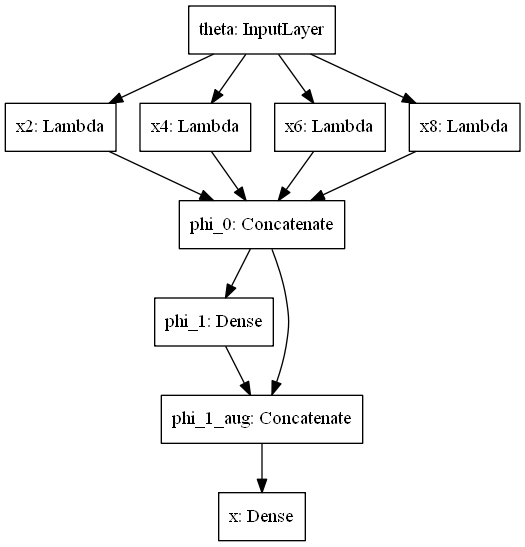

In [52]:
keras.utils.plot_model(model_cos_64, show_shapes=False)

In [53]:
model_cos_64.summary()

Model: "model_cos_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x2 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x4 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x6 (Lambda)                     (None, 1)            0           theta[0][0]                      
_____________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [54]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_64.load_weights('../models/polar/model_cos_[64].h5')
    model_cos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_64 = vartbl['hist_cos_64']
    print('Loaded model_cos_64.')
except:
    hist = compile_and_fit(model=model_cos_64, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_64 = hist.history
    vartbl['hist_cos_64'] = hist_cos_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 1.31e+00; elapsed 0:00:01
Epoch 0100; loss 3.60e-04; elapsed 0:00:12
Epoch 0200; loss 1.06e-04; elapsed 0:00:23
Epoch 0300; loss 7.41e-05; elapsed 0:00:34
Epoch 0400; loss 4.44e-05; elapsed 0:00:46
Epoch 0500; loss 3.00e-05; elapsed 0:00:57
Epoch 0600; loss 3.97e-05; elapsed 0:01:08
Epoch 0700; loss 3.43e-05; elapsed 0:01:19
Restoring model weights from the end of the best epoch.
Epoch 00729: early stopping


In [55]:
model_cos_64.evaluate(ds_p2c)

11/11 [==============================] - 0s 19ms/step - loss: 4.7526e-05 - mean_absolute_error: 0.0060


[4.7525938002350316e-05, 0.0060284967]

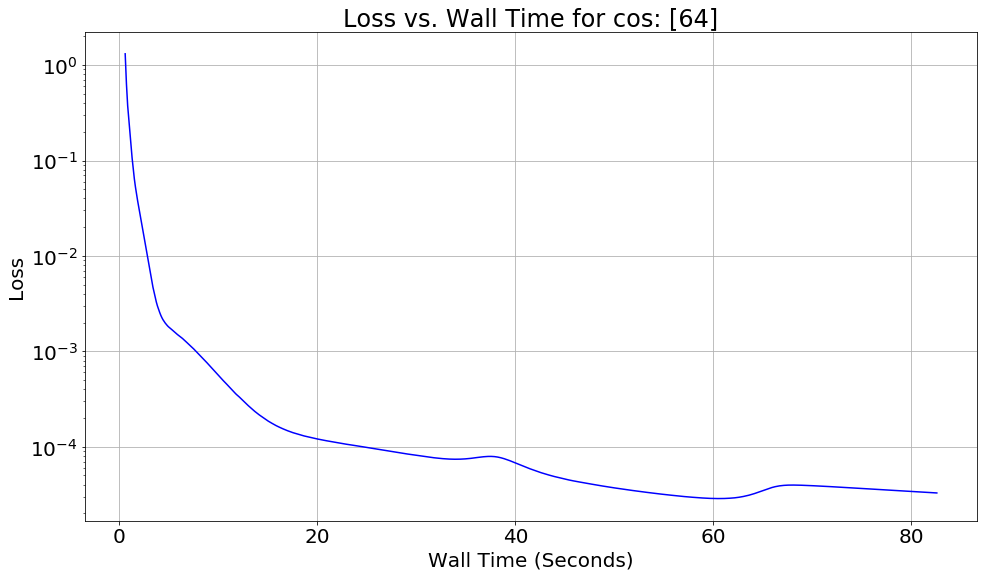

In [56]:
fig, ax = plot_loss_hist(hist_cos_64, 'cos: [64]')

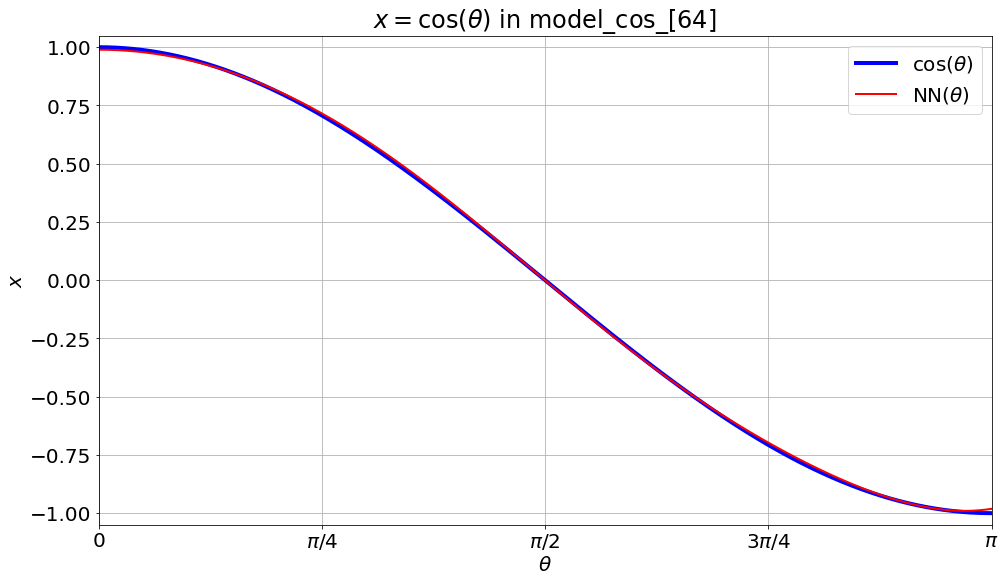

In [57]:
fig, ax = plot_pred_cos(model_cos_64, theta)

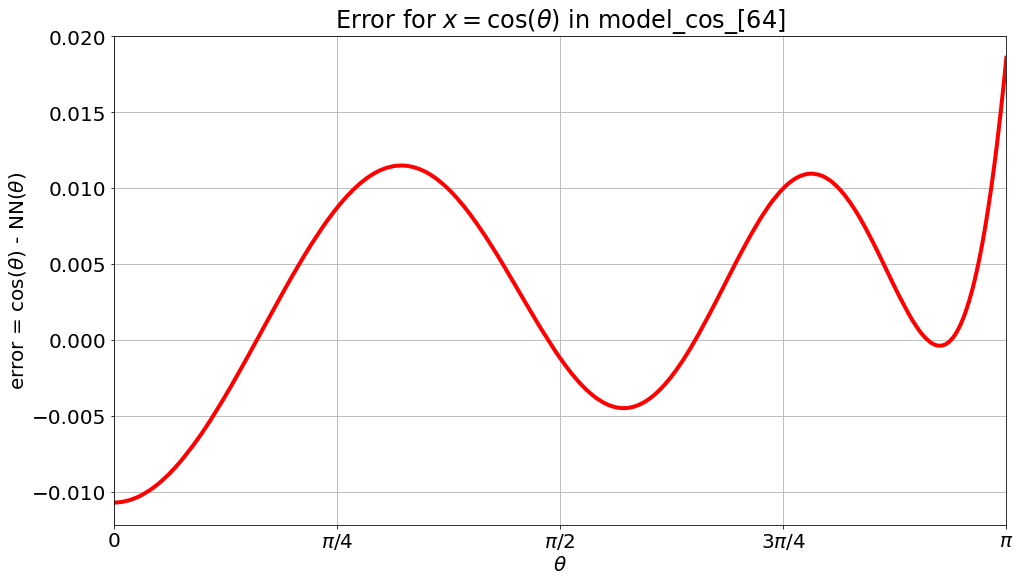

In [58]:
fig, ax = plot_error_cos(model_cos_64, theta)

### Network Design 2: [16, 16]
(model_cos_16_16 has two layers with 16 hidden units each)

In [60]:
model_cos_16_16 = make_model_pow(func_name='cos', 
                              input_name='theta',
                              output_name='x',
                              powers=[2,4,6,8],
                              skip_layers=True,
                              hidden_sizes=[16, 16])

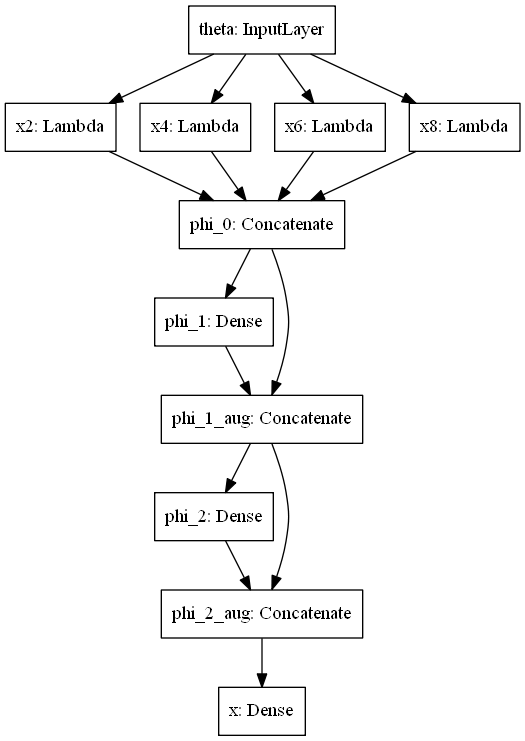

In [61]:
keras.utils.plot_model(model_cos_16_16)

In [62]:
model_cos_16_16.summary()

Model: "model_cos_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
theta (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
x2 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x4 (Lambda)                     (None, 1)            0           theta[0][0]                      
__________________________________________________________________________________________________
x6 (Lambda)                     (None, 1)            0           theta[0][0]                      
_________________________________________________________________________________

**Load the network and its loss history if available; otherwise train it**

In [63]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_cos_16_16.load_weights('../models/polar/model_cos_[16, 16].h5')
    model_cos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_cos_16_16 = vartbl['hist_cos_16_16']
    print('Loaded model_cos_16_16.')
except:
    hist = compile_and_fit(model=model_cos_16_16, 
                           ds=ds_p2c, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_cos_16_16 = hist.history
    vartbl['hist_cos_16_16'] = hist_cos_16_16
    save_vartbl(vartbl, fname)

Epoch 0001; loss 5.28e-01; elapsed 0:00:01
Epoch 0100; loss 1.72e-04; elapsed 0:00:13
Epoch 0200; loss 3.20e-05; elapsed 0:00:25
Epoch 0300; loss 1.13e-05; elapsed 0:00:37
Epoch 0400; loss 6.78e-06; elapsed 0:00:49
Epoch 0500; loss 3.52e-06; elapsed 0:01:02
Epoch 0600; loss 3.97e-06; elapsed 0:01:14
Epoch 0700; loss 4.54e-06; elapsed 0:01:26
Restoring model weights from the end of the best epoch.
Epoch 00775: early stopping


In [64]:
model_cos_16_16.evaluate(ds_p2c)

11/11 [==============================] - 0s 21ms/step - loss: 6.6369e-06 - mean_absolute_error: 0.0023


[6.636862115721504e-06, 0.0023343994]

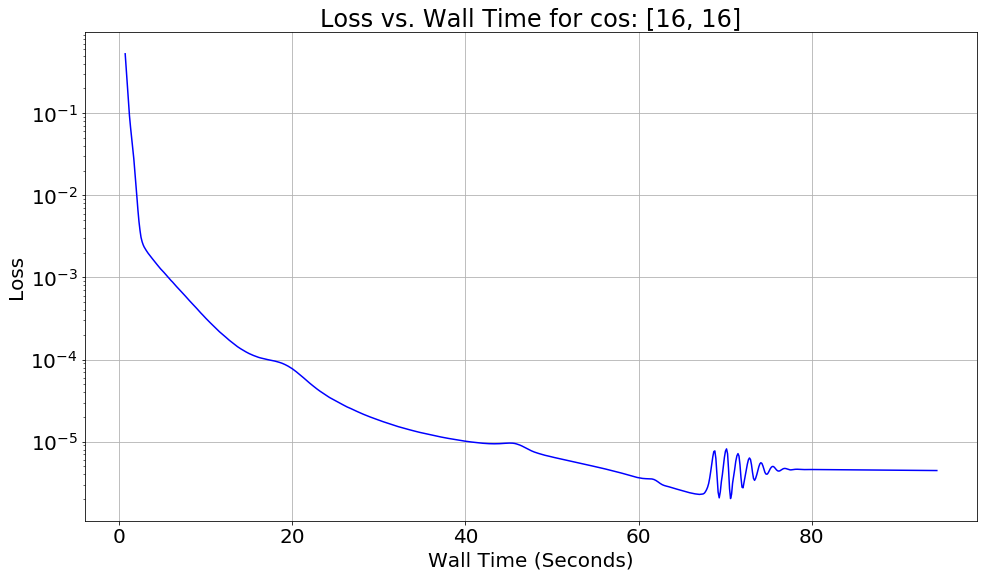

In [65]:
fig, ax = plot_loss_hist(hist_cos_16_16, 'cos: [16, 16]')

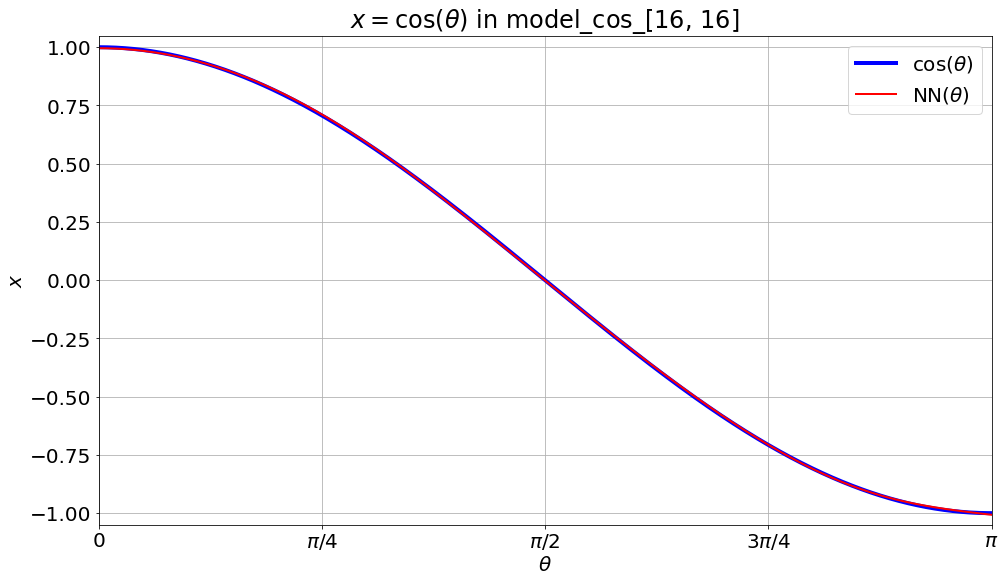

In [66]:
fig, ax = plot_pred_cos(model_cos_16_16, theta)

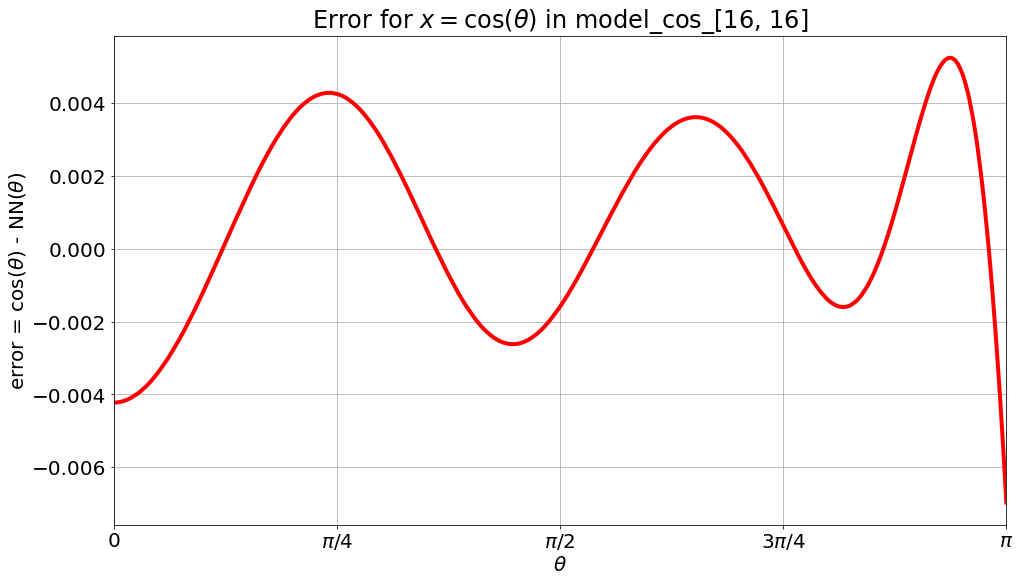

In [67]:
fig, ax = plot_error_cos(model_cos_16_16, theta)

## Neural networks for $\theta = \arccos(y)$

## Functions for visualizing neural network outputs $\theta = \arccos(y)$

In [68]:
def plot_pred_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'$\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.set_ylim(0.0, np.pi)
    ax.set_yticks(np.linspace(0.0, np.pi, 5))
    ax.set_yticklabels(['0', '$\pi/4$', '$\pi/2$', '$3\pi/4$', '$\pi$'])
    ax.plot(x, theta, color='blue', label='$\\arccos(x)$', linewidth=4.0)
    ax.plot(x, theta_pred, color='red', label='NN$(x)$', linewidth=2.0)
    ax.grid()
    ax.legend()
    return fig, ax

In [69]:
def plot_error_arccos(model, x):
    # Predictions of the model
    theta_pred = model.predict(x)
    theta_pred = theta_pred.reshape((-1,))
    error = theta - theta_pred
    
    # Plot predictions
    fig, ax = plt.subplots(figsize=[16,9])
    ax.set_title(f'Error in $\\theta = \\arccos(x)$ for {model.name}')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\\theta$')
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks(np.linspace(-1.0, 1.0, 9))
    ax.plot(x, error, color='red', label='error', linewidth=4.0)
    ax.grid()
    ax.legend()
    return fig, ax

### Network Design 1: [64]

In [82]:
model_arccos_64 = make_model_pow(func_name='arccos', 
                                 input_name = 'x',
                                 output_name='theta', 
                                 powers=[1,3,5,7],
                                 skip_layers=True,                                    
                                 hidden_sizes=[64])

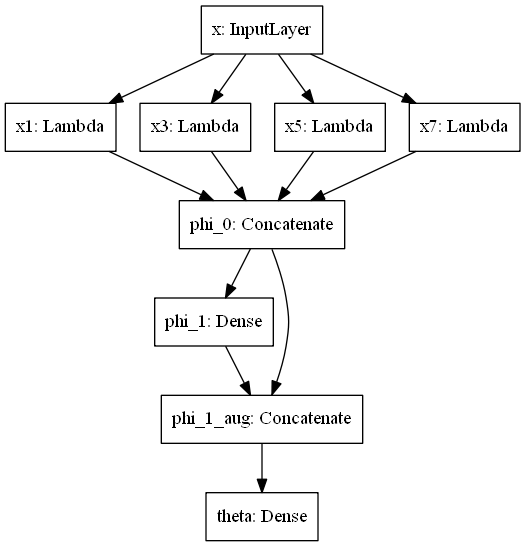

In [83]:
keras.utils.plot_model(model_arccos_64)

In [84]:
model_arccos_64.summary()

Model: "model_arccos_[64]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x1 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________

In [85]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_64.load_weights('../models/polar/model_arccos_[64].h5')
    model_arccos_64.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_64 = vartbl['hist_arccos_64']
    print('Loaded model_arccos_64.')
except:
    hist = compile_and_fit(model=model_arccos_64, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_64 = hist.history
    vartbl['hist_arccos_64'] = hist_arccos_64
    save_vartbl(vartbl, fname)

Epoch 0001; loss 3.41e+00; elapsed 0:00:01
Epoch 0100; loss 3.73e-03; elapsed 0:00:12
Epoch 0200; loss 2.16e-03; elapsed 0:00:24
Epoch 0300; loss 2.05e-03; elapsed 0:00:36
Epoch 0400; loss 1.95e-03; elapsed 0:00:48
Epoch 0500; loss 1.84e-03; elapsed 0:00:59
Epoch 0600; loss 1.73e-03; elapsed 0:01:11
Epoch 0700; loss 1.63e-03; elapsed 0:01:23
Epoch 0800; loss 1.54e-03; elapsed 0:01:35
Epoch 0900; loss 1.45e-03; elapsed 0:01:47
Epoch 1000; loss 1.36e-03; elapsed 0:01:58
Epoch 1100; loss 1.28e-03; elapsed 0:02:10
Epoch 1200; loss 1.21e-03; elapsed 0:02:22
Epoch 1300; loss 1.13e-03; elapsed 0:02:34
Epoch 1400; loss 1.06e-03; elapsed 0:02:46
Epoch 1500; loss 9.98e-04; elapsed 0:02:58
Epoch 1600; loss 9.39e-04; elapsed 0:03:10
Epoch 1700; loss 8.86e-04; elapsed 0:03:22
Epoch 1800; loss 8.41e-04; elapsed 0:03:34
Epoch 1900; loss 8.03e-04; elapsed 0:03:45
Epoch 2000; loss 7.72e-04; elapsed 0:03:58


In [86]:
model_arccos_64.evaluate(ds_c2p)

11/11 [==============================] - 0s 19ms/step - loss: 6.6688e-04 - mean_absolute_error: 0.0179


[0.0006668805435765535, 0.017863331]

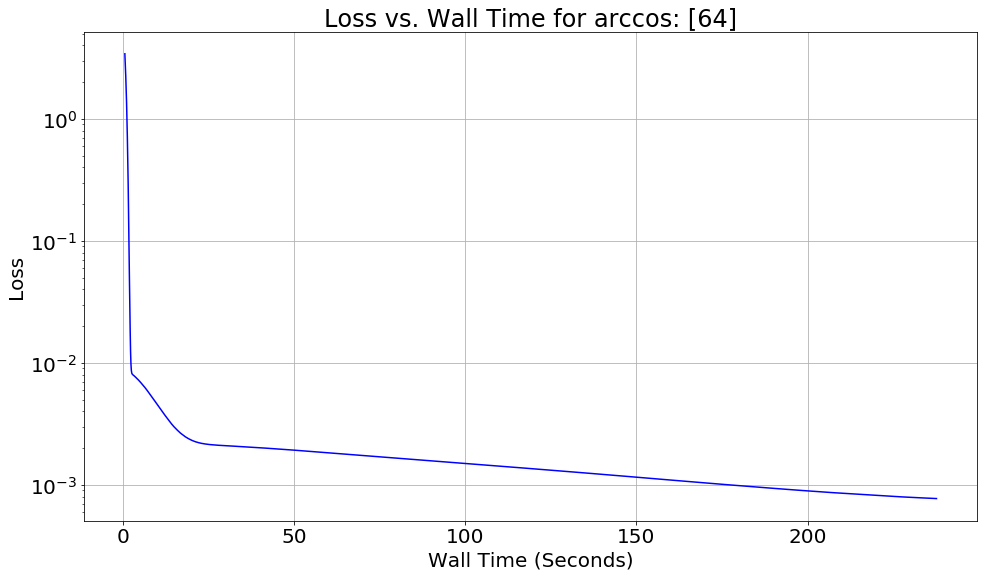

In [87]:
fig, ax = plot_loss_hist(hist_arccos_64, 'arccos: [64]')

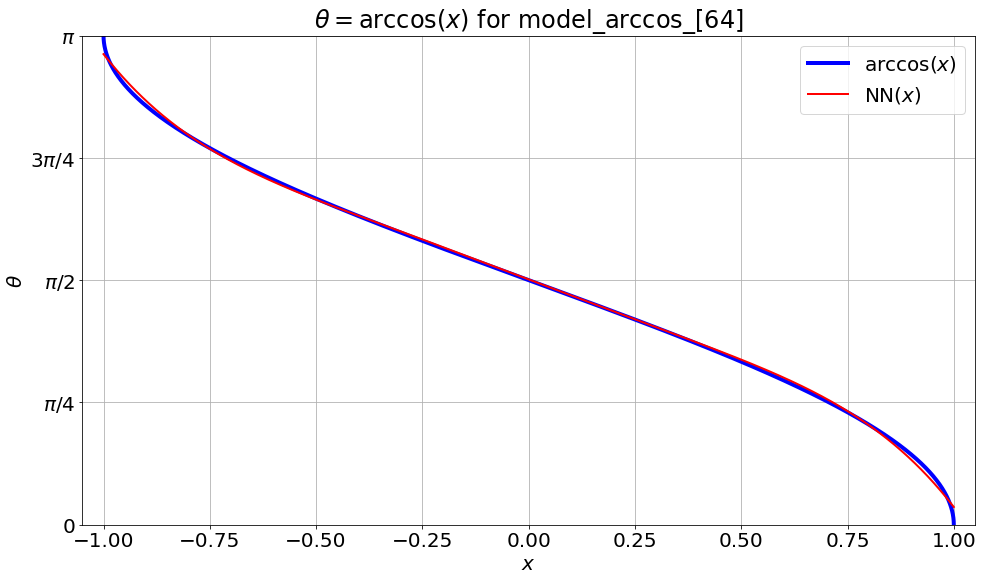

In [88]:
fig, ax = plot_pred_arccos(model_arccos_64, x)

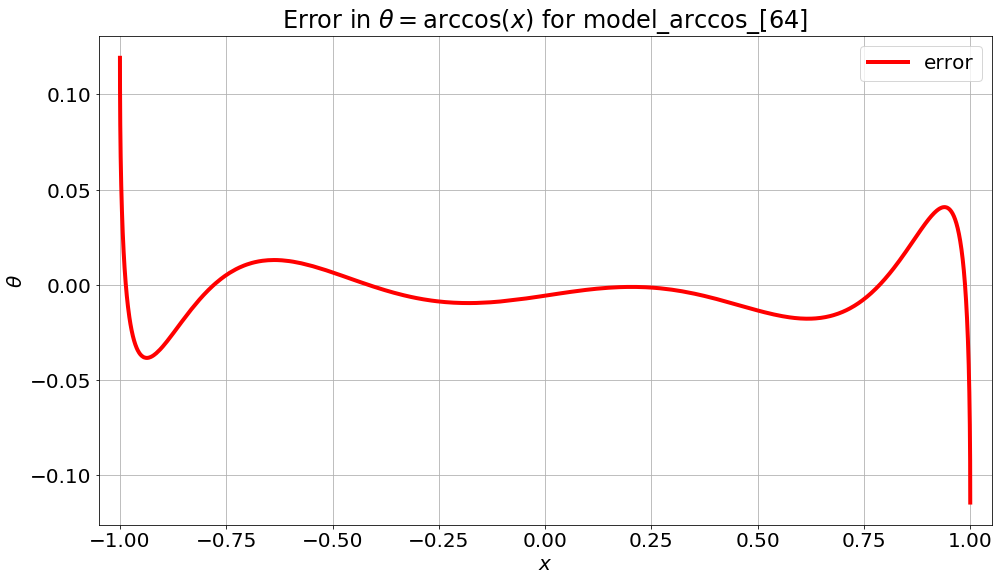

In [89]:
fig, ax = plot_error_arccos(model_arccos_64, x)

### Network Design 2: [16, 16]

In [90]:
model_arccos_16_16 = make_model_pow(func_name='arccos', 
                                    input_name = 'x',
                                    output_name='theta',
                                    powers=[1,3,5,7],
                                    skip_layers=True,                                    
                                    hidden_sizes=[16, 16])

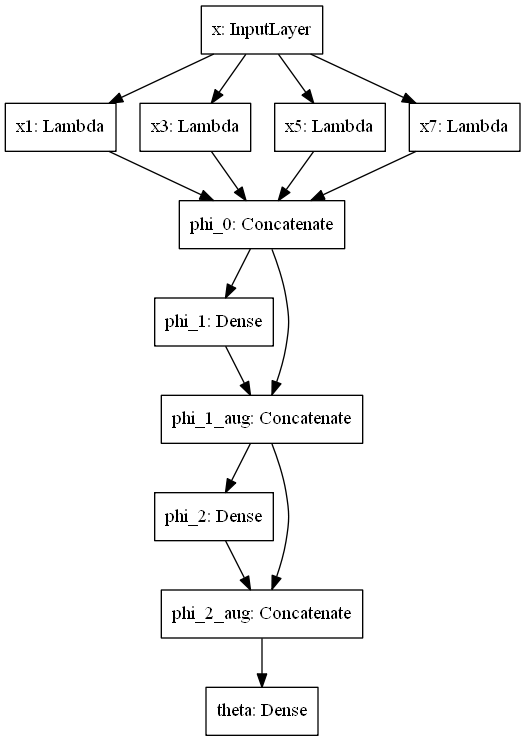

In [91]:
keras.utils.plot_model(model_arccos_16_16)

In [92]:
model_arccos_16_16.summary()

Model: "model_arccos_[16, 16]"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
x1 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x3 (Lambda)                     (None, 1)            0           x[0][0]                          
__________________________________________________________________________________________________
x5 (Lambda)                     (None, 1)            0           x[0][0]                          
______________________________________________________________________________

In [93]:
loss=keras.losses.MeanSquaredError()
optimizer=keras.optimizers.Adam(learning_rate=1.0E-3)

try:
    model_arccos_16_16.load_weights('../models/polar/model_arccos_[16, 16].h5')
    model_arccos_16_16.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    hist_arccos_16_16 = vartbl['hist_arccos_16_16']
    print('Loaded model_arccos_16_16.')
except:
    hist = compile_and_fit(model=model_arccos_16_16, 
                           ds=ds_c2p, 
                           epochs=epochs,
                           loss=loss, 
                           optimizer=optimizer,
                           metrics=metrics,
                           save_freq=save_freq)
    hist_arccos_16_16 = hist.history
    vartbl['hist_arccos_16_16'] = hist_arccos_16_16
    save_vartbl(vartbl, fname)

Epoch 0001; loss 2.41e+00; elapsed 0:00:01
Epoch 0100; loss 2.97e-03; elapsed 0:00:13
Epoch 0200; loss 2.30e-03; elapsed 0:00:26
Epoch 0300; loss 1.93e-03; elapsed 0:00:39
Epoch 0400; loss 1.67e-03; elapsed 0:00:52
Epoch 0500; loss 1.48e-03; elapsed 0:01:04
Epoch 0600; loss 1.23e-03; elapsed 0:01:17
Epoch 0700; loss 1.03e-03; elapsed 0:01:29
Epoch 0800; loss 9.95e-04; elapsed 0:01:41
Epoch 0900; loss 9.80e-04; elapsed 0:01:54
Epoch 1000; loss 9.62e-04; elapsed 0:02:06
Epoch 1100; loss 9.45e-04; elapsed 0:02:19
Epoch 1200; loss 9.29e-04; elapsed 0:02:31
Epoch 1300; loss 9.15e-04; elapsed 0:02:44
Epoch 1400; loss 9.02e-04; elapsed 0:02:56
Epoch 1500; loss 8.90e-04; elapsed 0:03:09
Epoch 1600; loss 8.79e-04; elapsed 0:03:21
Epoch 1700; loss 8.67e-04; elapsed 0:03:33
Epoch 1800; loss 8.57e-04; elapsed 0:03:46
Epoch 1900; loss 8.46e-04; elapsed 0:03:58
Epoch 2000; loss 8.35e-04; elapsed 0:04:11


In [94]:
model_arccos_16_16.evaluate(ds_c2p)

11/11 [==============================] - 0s 24ms/step - loss: 7.1276e-04 - mean_absolute_error: 0.0208


[0.0007127577502449805, 0.020775711]

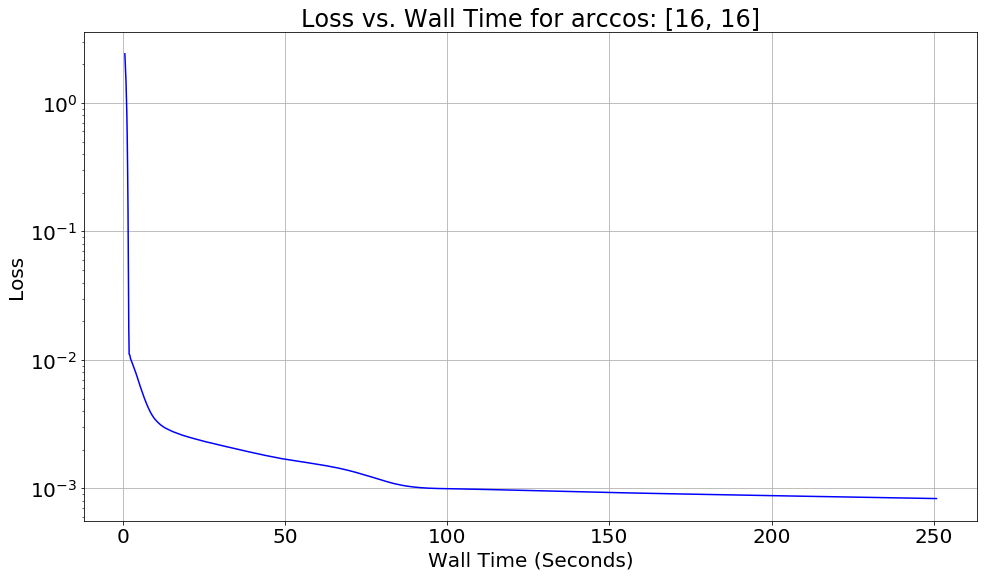

In [95]:
fig, ax = plot_loss_hist(hist_arccos_16_16, 'arccos: [16, 16]')

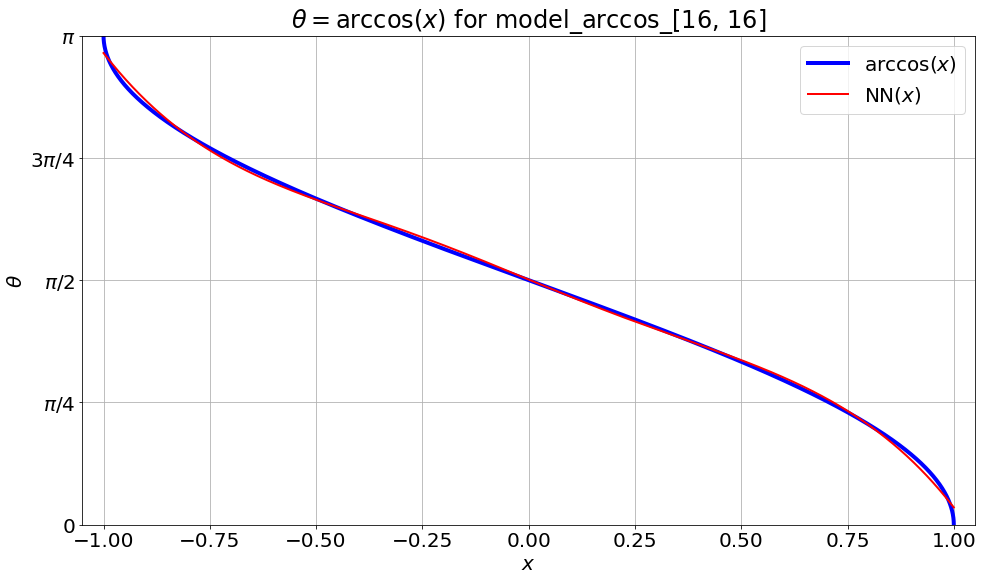

In [96]:
fig, ax = plot_pred_arccos(model_arccos_16_16, x)

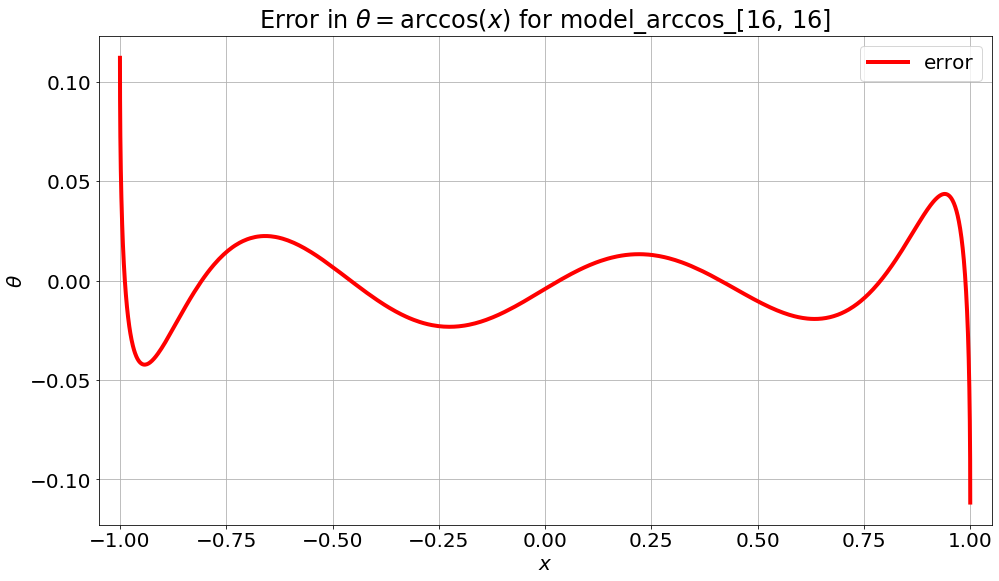

In [97]:
fig, ax = plot_error_arccos(model_arccos_16_16, x)

In [98]:
# copies of model instances
model_cos = keras.models.clone_model(model_cos_16_16)
model_cos.set_weights(model_cos_16_16.get_weights())
model_arccos = keras.models.clone_model(model_arccos_16_16)
model_arccos.set_weights(model_arccos_16_16.get_weights())

# remove special characters from model names
# otherwise make_model_autoencoder fails with invalid scope name due to [16, 16] in model names
model_cos._name = 'model_cos'
model_arccos._name = 'model_arccos'

In [99]:
model_p2p, model_c2c = make_model_autoencoder(
    model_p2c = model_cos,
    model_c2p = model_arccos)

In [101]:
model_p2p.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_p2p.evaluate(ds_p2p)

11/11 [==============================] - 0s 28ms/step - loss: 0.8684 - mean_absolute_error: 0.7811


[0.8684185418215665, 0.78113097]

In [102]:
model_c2c.compile(loss=loss, optimizer=optimizer, metrics=metrics)
model_c2c.evaluate(ds_c2c)

11/11 [==============================] - 0s 28ms/step - loss: 1.3788 - mean_absolute_error: 0.9946


[1.3788453123786233, 0.9945503]